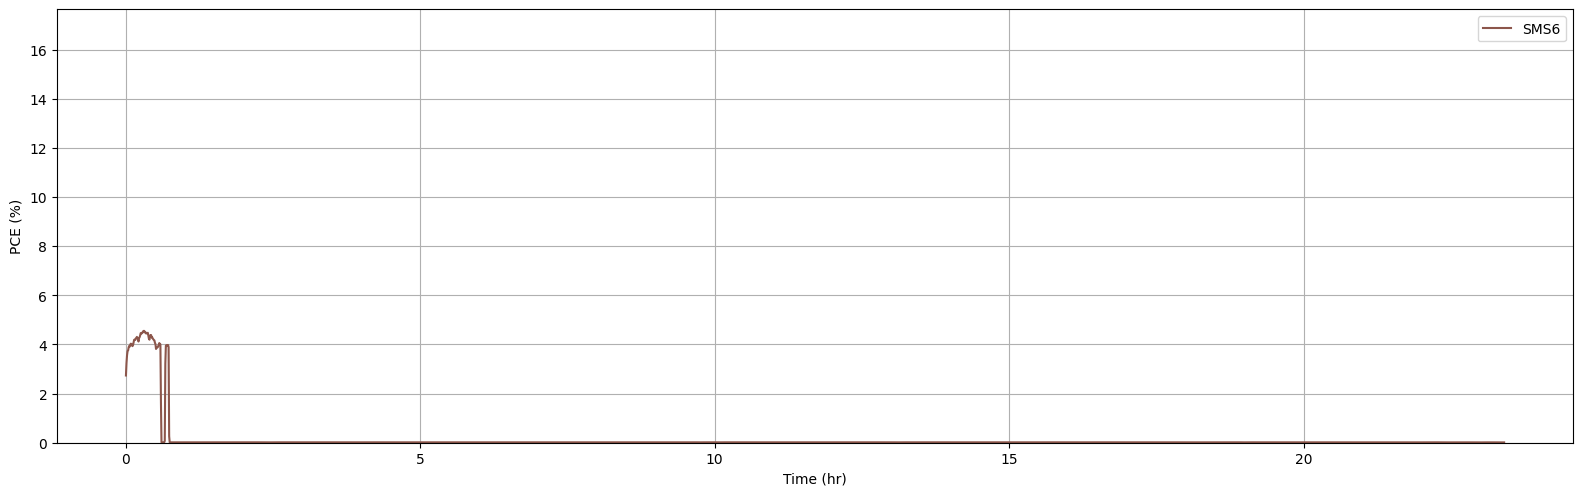

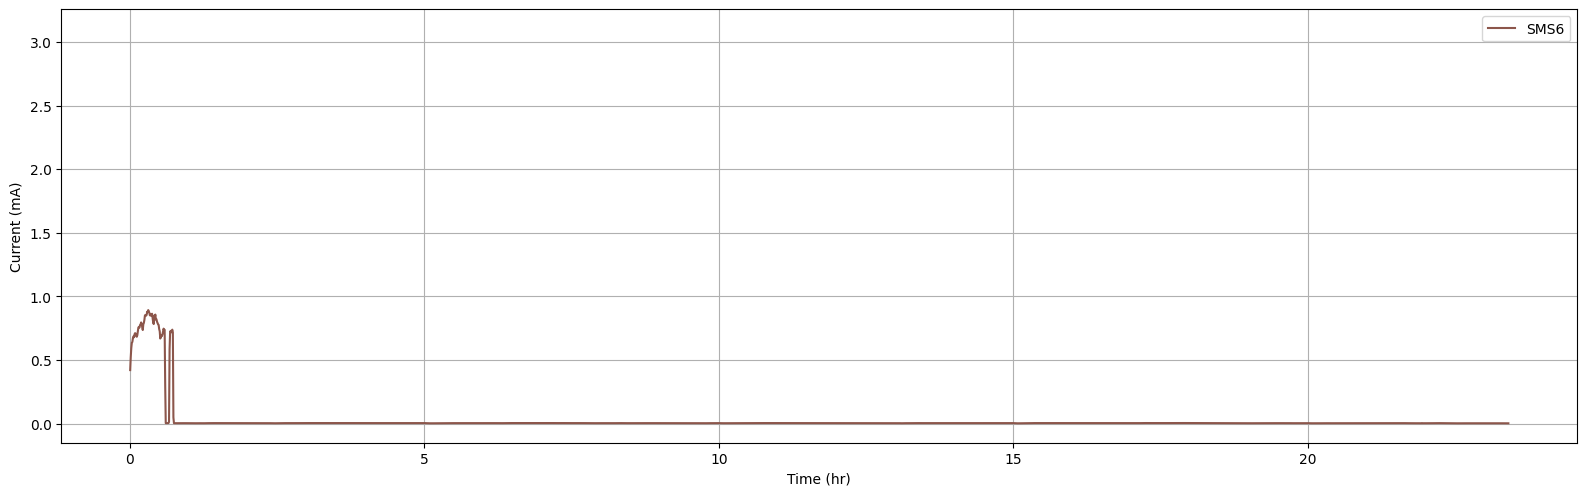

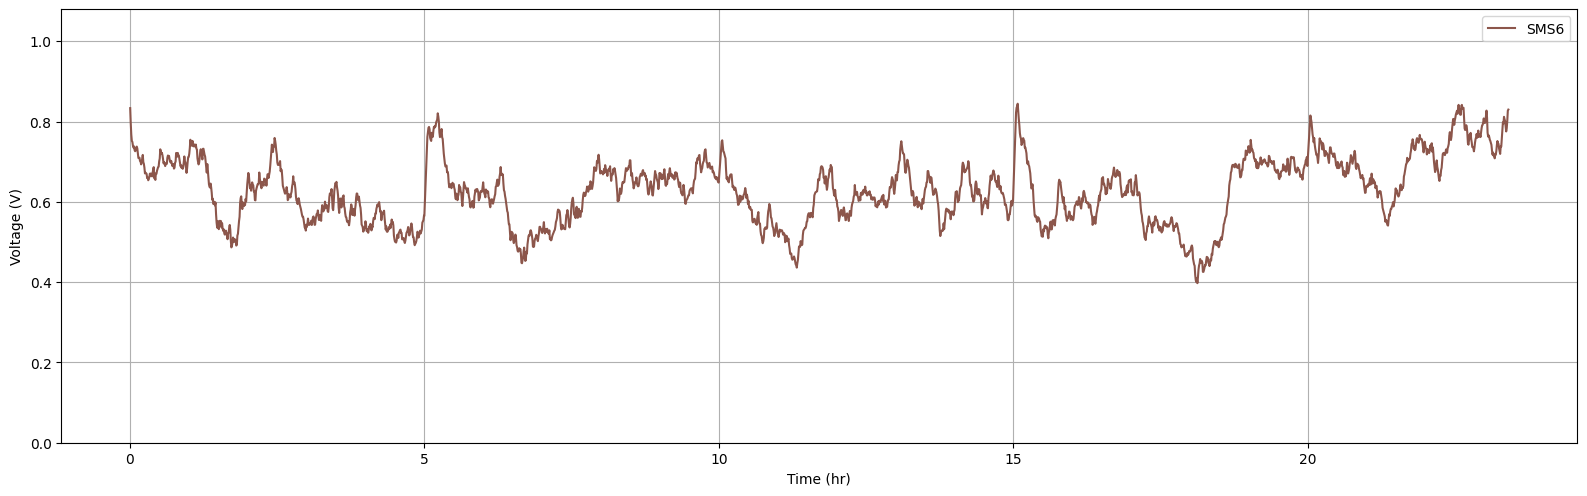

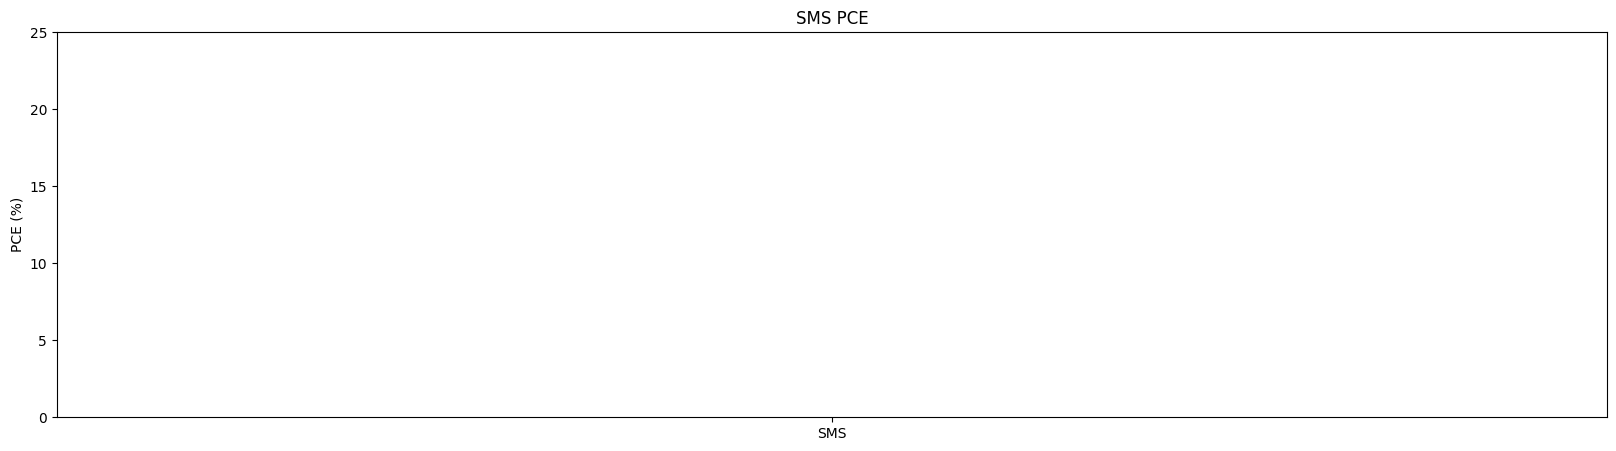

Average Across Device (PCE) nan
Average Across All Devices nan


c:\Users\achen\miniconda3\envs\stabilitySetup\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\achen\miniconda3\envs\stabilitySetup\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# %matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
from labellines import labelLines
from matplotlib.font_manager import FontProperties
import os
import sys
import re
np.set_printoptions(threshold=sys.maxsize)
from matplotlib.cbook import boxplot_stats


def get_outlier_indices(data):
	data = np.asarray(data)
	q1 = np.percentile(data, 25)
	q3 = np.percentile(data, 75)
	iqr = q3 - q1

	lower_bound = q1 - 1.5 * iqr
	upper_bound = q3 + 1.5 * iqr

	outlier_mask = (data < lower_bound) | (data > upper_bound)
	return np.where(outlier_mask)[0]
def plot_current(mA_density, time_label, time):

	bottom = np.min(mA_density)*0.95
	top = np.max(mA_density)*1.05

	plt.figure(figsize=plot_size)
	plt.ylim(bottom = bottom, top = top)
	plt.xlabel(time_label)
	plt.grid()
	plt.ylabel('Current (mA)')
	plt.subplots_adjust(left=0.086,
						bottom=0.06,
						right=0.844,
						top=0.927,
						wspace=0.2,
						hspace=0.2)
	colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

	for i in plot_range:
		lineName = "mA" + str(i + 1)
		plt.plot(time,
					mA_density[:,i],
					color=colors[i % len(colors)],
					label = "SMS"+ str(i+1))

	# plt.legend(bbox_to_anchor=legend_anchor)
	plt.legend()
	plt.show()

def plot_voltage(v, time_label, time):
	plt.figure(figsize=plot_size)
	bottom = np.min(v)*0.95
	top = np.max(v)*1.05
	plt.ylim(bottom = bottom, top = top)
	plt.xlabel(time_label)
	plt.grid()
	plt.ylabel('Voltage (V)')
	plt.subplots_adjust(left=0.086,
						bottom=0.06,
						right=0.844,
						top=0.927,
						wspace=0.2,
						hspace=0.2)
	colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

	for i in plot_range:
		lineName = "V" + str(i + 1)
		plt.plot(time,
					v[:,i],
					color=colors[i % len(colors)],
					label = "SMS"+ str(i+1))
	# plt.legend(bbox_to_anchor=legend_anchor)
	plt.legend()
	plt.show()

def plot_difference(ss_file_path = "", plot_range = [], time_limit = -1, plot_size = (12,10), remove_outliers = False, roll = 0, plot = True):
	all_files = []

	data = []
	mA_density = []
	v = []
	cell_area = 0
	if ss_file_path != "":
		arr = np.loadtxt(ss_file_path, delimiter=",", dtype=str)
		header_row = np.where(arr == "Time")[0][0]

		meta_data = {}
		for data in arr[:header_row, :2]:
			meta_data[data[0]] = data[1]

		headers = arr[header_row, :]
		arr = arr[header_row + 1 :, :]

		header_dict = {value: index for index, value in enumerate(headers)}
		time = np.array(arr[:, header_dict["Time"]]).astype("float")
		time /= 60

		pixel_V = arr[:, 1::2][:, 0:8].astype(float)
		pixel_mA = arr[:, 2::2][:, 0:8].astype(float)
		pixel_V = np.roll(pixel_V, roll, axis = 1)
		pixel_mA = np.roll(pixel_mA, roll, axis = 1)

		cell_area = float(meta_data["Cell Area (mm^2)"])
		mA_density = pixel_mA

		v = pixel_V

		data = ((pixel_V*pixel_mA/1000) / (0.1*cell_area))*100

		# calculation in minutes
		max_time = time[-1]
		if max_time > time_limit and time_limit > 0:
			end_idx = np.searchsorted(time, time_limit)
			time = time[:end_idx]
			data = data[:end_idx,:]
			mA_density = mA_density[:end_idx,:]
			v = pixel_V[:end_idx,:]
	time_label = "Time (min)"
	if max(time) > 60:
		time /= 60
		time_label = "Time (hr)"

	average_sms = []
	if plot:
		plt.figure(figsize=plot_size)
		bottom = np.min(data)*0.95
		top = np.max(data)*1.05

		plt.ylim(bottom = 0, top = top)
		plt.xlabel(time_label)
		plt.grid()
		colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

		plt.ylabel('PCE (%)')
		plt.subplots_adjust(left=0.086,
							bottom=0.06,
							right=0.844,
							top=0.927,
							wspace=0.2,
							hspace=0.2)
	for i in plot_range:
		if ss_file_path and plot:
			plt.plot(time,
					data[:,i],
					color=colors[i % len(colors)],
					label = "SMS"+ str(i+1))
		if ss_file_path:
			second_half = data[:,i][len(data[:,i]) // 2:]
			average_second_half = np.mean(second_half)

			if average_second_half > 2.5:
				average_sms.append(average_second_half)

		if plot:
			lines = plt.gca().get_lines()
			x_min, x_max = plt.xlim()
			num_lines = len(lines)
		# legend_anchor = (1, 0.2)
		# plt.legend(bbox_to_anchor=legend_anchor)
	if plot:
		plt.legend()
		plt.savefig(
			"MPPT_Plot.png",         # output filename (extension defines format)
			dpi=300,               # resolution in dots per inch
		)
		# plt.show()

	plot_current(mA_density, time_label, time)
	plot_voltage(v, time_label, time)



	average_sms = np.array(average_sms)

	try:
		outliers = np.unique(get_outlier_indices(average_sms))
	except:
		outliers = []
	filtered_sms = np.delete(average_sms, outliers)

	if plot:
		box_plot = [average_sms]
		labels = ["SMS"]

		# Optional: compute stats using matplotlib's utility
		stats = boxplot_stats(box_plot)
		fig, ax = plt.subplots(figsize=plot_size)
		bp = ax.boxplot(box_plot, flierprops=dict(marker='o', markersize=0))
		ax.set_ylim(0, 25)

		for i, stat in enumerate(stats, start=1):
			outliers = stat['fliers']  # already identified!

			if len(outliers) > 0:
				jitter = 0.2 * (np.random.rand(len(outliers)) - 0.5)  # random horizontal spread
				x_positions = np.full(len(outliers), i) + jitter
				ax.scatter(x_positions, outliers, color='white', edgecolor='black', zorder=3)

		# Label the x-axis
		ax.set_xticks([1])
		ax.set_title("SMS PCE")
		ax.set_ylabel("PCE (%)")
		ax.set_xticklabels(labels)
		plt.show()


	if remove_outliers:
		return filtered_sms
	else:
		return average_sms

r"""
Best

cas search = _5_0

for i in range(1,5):
	files.append([
		rf"C:\Users\Andrew Chen\Dropbox\code\Stability-Setup\data\April-03-2025 cas\devices\{i}",
		rf"C:\Users\Andrew Chen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-57-33__ID{i}__mppt.csv"
	])

"""

# # TRIAL WITH CAS HOLDER
sms_files = [
    rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Jul-30-2025 13_43_35\Combined__ID1__mppt.csv",
    # rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\May-04-2025 11_18_15\May-04-2025_11-21-10__ID1__compressedmppt.csv",
    # rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\May-04-2025 11_18_15\May-04-2025_11-21-10__ID2__compressedmppt.csv",
    # rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\May-04-2025 11_18_15\May-04-2025_11-21-10__ID3__compressedmppt.csv",
    # rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\May-04-2025 11_18_15\May-04-2025_11-21-10__ID4__compressedmppt.csv",
]

# TRIAL WITH SAMPLE HOLDER
# sms_files = [
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-27-31__ID1__mppt.csv",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-33-16__ID2__mppt.csv",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-33-16__ID3__mppt.csv",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-27-31__ID4__mppt.csv",
# ]
# cas_files = [
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\1",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\2",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\3",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\4",
# ]

plot_range = [x for x in range(5,6)]
printouts = []
all_diff = []
average_sms = []
plot_size = (20,5)
for ss_file in sms_files:
	temp_sms = plot_difference(ss_file, plot_range, plot_size = plot_size, remove_outliers=False, roll = 0)
	sms = np.mean(temp_sms)

	average_sms.extend(temp_sms)
	print(f"Average Across Device (PCE) {sms}")

average_sms = np.asarray(average_sms)


# # Print stats for each label
# for label, stat in zip(labels, stats):
#     print(f"--- {label} ---")
#     print(f"Min: {stat['whislo']}")
#     print(f"Q1 : {stat['q1']}")
#     print(f"Med: {stat['med']}")
#     print(f"Q3 : {stat['q3']}")
#     print(f"Max: {stat['whishi']}")
#     print(f"Outliers: {stat['fliers']}")
#     print()


print(f"Average Across All Devices {np.mean(average_sms)}")


